# VLM Inference
Test the trained Vision-Language Model on images.

In [1]:
import os
os.chdir('..')  # Change to vision_language_alignment directory
print(f"Working directory: {os.getcwd()}")

Working directory: /home/smedar/code_files/llama4-from-scratch/vision_language_alignment


In [2]:
import torch
from PIL import Image
from pathlib import Path
import tomllib
import requests
from io import BytesIO

from model import create_vlm, DEFAULT_CONFIG, DEFAULT_LLM_CKPT
from dataset import get_image_transform, get_tokenizer

## Load Model

In [3]:
# Load config
with open(DEFAULT_CONFIG, "rb") as f:
    cfg = tomllib.load(f)

# Create model
model = create_vlm(cfg, str(DEFAULT_LLM_CKPT))

# Load trained checkpoint
checkpoint = torch.load("checkpoints/best_vlm.pt", map_location="cpu")
model.load_state_dict(checkpoint["model_state_dict"])

model = model.cuda().eval()
print(f"Model loaded! Val loss was: {checkpoint.get('val_loss', 'N/A'):.4f}")

Loading LLM checkpoint from: /home/smedar/code_files/llama4-from-scratch/text_pretraining/checkpoints/best.pt
LLM checkpoint loaded successfully
Model loaded! Val loss was: 3.2270


In [4]:
# Load tokenizer and transforms
tokenizer = get_tokenizer()
transform = get_image_transform()

# Token IDs
IMAGE_TOKEN = tokenizer.token_to_id("<image>")
EOS_TOKEN = tokenizer.token_to_id("</s>")
print(f"<image> ID: {IMAGE_TOKEN}, </s> ID: {EOS_TOKEN}")

Loaded tokenizer from /home/smedar/code_files/llama4-from-scratch/vision_language_alignment/bpe_tokenizer_with_image_tag.json
Vocab size: 32001
<image> ID: 32000, </s> ID: 2


## Generate Caption Function

In [5]:
@torch.no_grad()
def generate_caption(image, max_tokens=50):
    """Generate caption for a PIL image."""
    # Preprocess
    if image.mode != 'RGB':
        image = image.convert('RGB')
    img_tensor = transform(image).unsqueeze(0).cuda()
    
    # Start with <image> token
    input_ids = torch.tensor([[IMAGE_TOKEN]], device="cuda")
    tokens = []
    
    for _ in range(max_tokens):
        logits = model(img_tensor, input_ids)
        next_token = logits[0, -1, :].argmax().item()
        
        if next_token == EOS_TOKEN:
            break
            
        tokens.append(next_token)
        input_ids = torch.cat([input_ids, torch.tensor([[next_token]], device="cuda")], dim=1)
    
    return tokenizer.decode(tokens)

In [6]:
def load_image(source):
    """Load image from URL or file path."""
    if source.startswith('http'):
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(source, headers=headers)
        return Image.open(BytesIO(response.content))
    return Image.open(source)

def caption(source):
    """Display image and generate caption."""
    img = load_image(source)
    display(img.resize((300, 300)))
    text = generate_caption(img)
    print(f"Caption: {text}")

## Test on Images

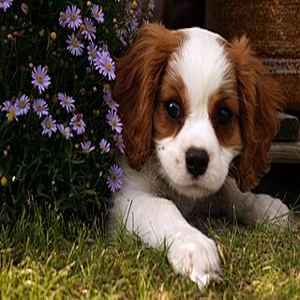

Caption:  A small dog is sitting on a grassy field.


In [7]:
# Test 1: Dog
caption("https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/Cute_dog.jpg/320px-Cute_dog.jpg")

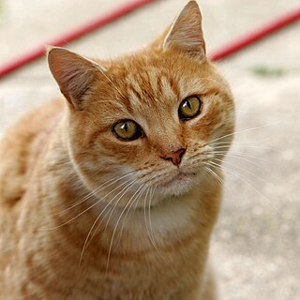

Caption:  A cat is sitting on a grassy area.


In [8]:
# Test 2: Cat
caption("https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/320px-Cat03.jpg")

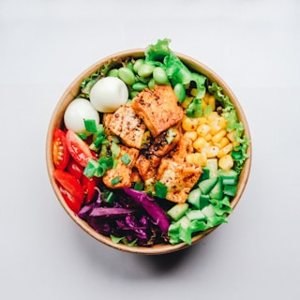

Caption:  A bowl of food is placed on a table.


In [9]:
# Test 3: Food
caption("https://images.unsplash.com/photo-1546069901-ba9599a7e63c?w=320")

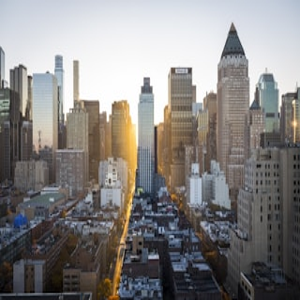

Caption:  A busy city with lots of buildings and people.


In [10]:
# Test 4: City/Street
caption("https://images.unsplash.com/photo-1480714378408-67cf0d13bc1b?w=320")

## Try Your Own Images

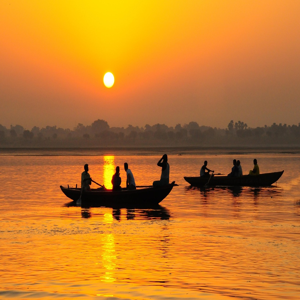

Caption:  A group of people in a water with a boat in the water.


In [11]:
caption("/home/smedar/code_files/llama4-from-scratch/vision_language_alignment/notebooks/sample_image.png")